# SQLAlchemy and Flask Challenge

## Step 1 - Climate Analysis and Exploration

In [1]:
# Import Dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

#### Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create a new engine instance
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Precipitation Analysis

- Design a query to retrieve the last 12 months of precipitation data.
- Select only the date and prcp values.
- Load the query results into a Pandas DataFrame and set the index to the date column.
- Plot the results using the DataFrame plot method.

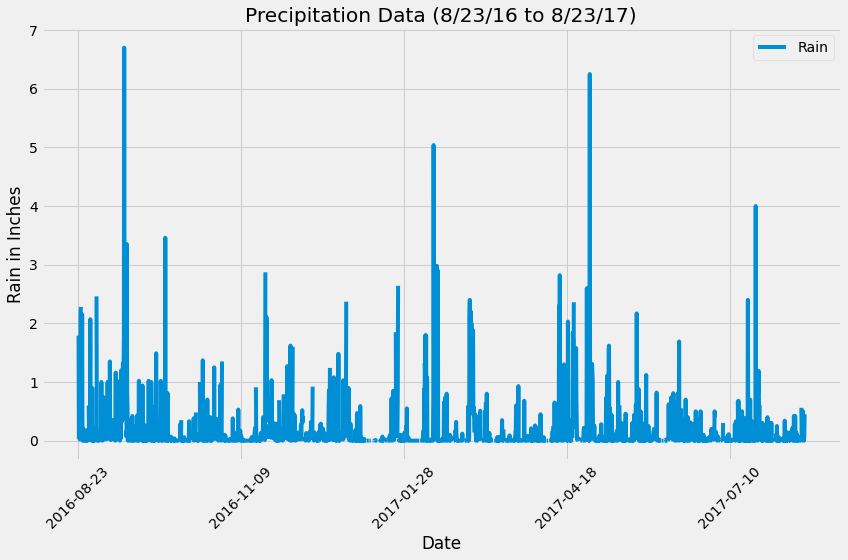

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# get the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# get the last 12 months of data, last date - 365
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(query)

# Sort the dataframe by date
rain_df = rain_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp', figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Data (8/23/16 to 8/23/17)")
plt.legend(["Rain"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Figures/Precipitation.png")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

- Design a query to calculate the total number of stations.
- Design a query to find the most active stations.
- List the stations and observation counts in descending order
- Which station has the highest number of observations?
- Design a query to retrieve the last 12 months of temperature observation data (tobs).
- Filter by the station with the highest number of observations.
- Plot the results as a histogram with bins=12.

In [13]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(Station.id).count()
print(f"There are {num_station} stations in the dataset.")

There are 9 stations in the dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station). \
                order_by(func.count(Measurement.station).desc()).all()

station_count = {station: count for station, count in station_count}

print('Stations and Counts:')
print('--------------------')
for station,count in station_count.items():
    print(station,count)
print('====================')

Stations and Counts:
--------------------
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
avg_temp = "{0:.1f}".format(active_station[0][2])
print(f"Min Temp Recorded: {active_station[0][0]}F \n\
Max Temp Recorded: {active_station[0][1]}F \n\
Average Temp recorded: {avg_temp}F")

Min Temp Recorded: 54.0F 
Max Temp Recorded: 85.0F 
Average Temp recorded: 71.7F


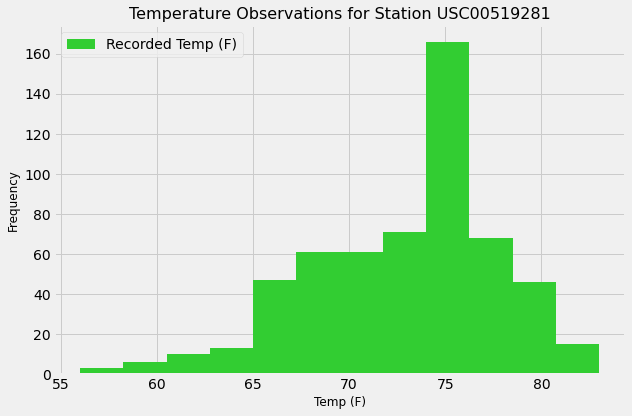

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.station == 'USC00519281', Measurement.date >= prev_year).all()

station_data = pd.DataFrame(station_data, columns=['tobs', 'date'])

#Plot the results as a histogram with bins=12
plt.figure(figsize=(9,6))
plt.hist(station_data['tobs'].values, bins=12, color='limegreen')
plt.ylabel('Frequency',size=12)
plt.xlabel('Temp (F)',size=12)
plt.legend(['Recorded Temp (F)'])
plt.title(f'Temperature Observations for Station USC00519281',size=16)
plt.tight_layout()
plt.savefig('Figures/tobsCountHistogram.png')
plt.show()

### Temperature Analysis I
- Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
- Use SQLAlchemy or Pandas's read_csv() to perform this portion.
- Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
- Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [49]:
hawaii_measurements=pd.read_csv('Resources/hawaii_measurements.csv')
hawaii_stations=pd.read_csv('Resources/hawaii_stations.csv')
hawaii_measurements.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [50]:
#Finding average temperature by grouping by 
june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].\
groupby(hawaii_measurements['station']).mean()

#Display output
june_temp['tobs']

station
USC00511918    74.139394
USC00513117    74.050847
USC00514830    76.005376
USC00516128    71.937220
USC00517948    76.655405
USC00518838    73.394737
USC00519281    73.271186
USC00519397    77.559322
USC00519523    76.668103
Name: tobs, dtype: float64

In [51]:
#Finding average temperature by grouping by
dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].\
groupby(hawaii_measurements['station']).mean()

#Display output
dec_temp['tobs']

station
USC00511918    69.684211
USC00513117    71.069444
USC00514830    73.224719
USC00516128    69.291262
USC00517948    71.834862
USC00518838    72.421053
USC00519281    69.903226
USC00519397    71.109524
USC00519523    72.433333
Name: tobs, dtype: float64

In [52]:
# Calculate Independent (Two Sample) T-Test
import scipy.stats as stats
stats.ttest_ind(june_temp['tobs'], dec_temp['tobs'], equal_var=False)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

An unpaired T-Test would be more appropriate to analyze this data because the data of June and December are independent. Also, this data is considered ex-post facto. Therefore, repeated measures for the same dates were not collected as seen in paired T-Test. 

If the null hypothesis stated that there is a meaningful difference in the temperature in Hawaii in the months of June and December, then one would have to reject this null hypothesis because the pvalue is 0.0003.

### Temperature Analysis II

- The function calc_temps accepts a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
- Using the calc_temps function calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year 
- Plot the min, avg, and max temperature from your previous query as a bar chart.
- Use the average temperature as the bar height.
- Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [43]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = "2017-01-20 to 2017-01-27"
prev_year = "2016-01-20 - \n 2016-01-27"

prev_year_start = dt.date(2017, 1, 20) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 1, 27) - dt.timedelta(days=365)

temps = calc_temps(prev_year_start, prev_year_end)
temp_min, temp_avg, temp_max = temps[0]

print(f" Min Temp : {temp_min}F")
print(f" Avg Temp : {temp_avg}F")
print(f" Max Temp : {temp_max}F")

 Min Temp : 64.0F
 Avg Temp : 70.12F
 Max Temp : 78.0F


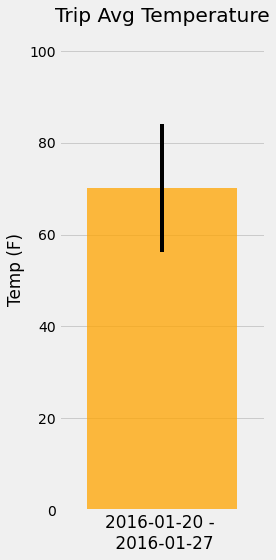

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = temp_max - temp_min
xpos = 1

plt.figure(figsize=(4, 8))
plt.bar(xpos, temp_avg, yerr=error, alpha=0.75, color="orange")
plt.title(f"Trip Avg Temperature")
plt.xlabel(f"{prev_year}")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.yticks(np.arange(0, 120, 20))
plt.tight_layout()
plt.xlim(0.45, 1.55)
plt.ylim(0, 105)
plt.savefig("Figures/Average Temp.png")

### Daily Rainfall Average

- Calculate the rainfall per weather station using the previous year's matching dates.
- Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
- The function called daily_normals will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.
- Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
- Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
- Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_dates = "2017-01-20 to 2017-01-27"
prev_year = "2016-01-20 - \n 2016-01-27"

prev_year_start = dt.date(2017, 1, 20) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 1, 27) - dt.timedelta(days=365)

rain_station = (
    session.query(
        func.avg(Measurement.prcp),
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(prev_year_start, prev_year_end),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)

# Convert query object to data frame
rain_df = pd.DataFrame(np.array(rain_station))
rain_df = rain_df.rename(
    columns={
        0: "Total Precipitation",
        1: "Station",
        2: "Location",
        3: "Latitude",
        4: "Longitude",
        5: "Elevation",
    }
)

rain_df

,Total Precipitation,Station,Location,Latitude,Longitude,Elevation
0,0.1575,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.3356,-157.711,19.5
1,0.155,USC00519281,"WAIHEE 837.5, HI US",21.4517,-157.849,32.9
2,0.07125,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.802,14.6
3,0.06875,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.803,152.4
4,0.03,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.837,7
5,0.02625,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.817,3
6,None,USC00517948,"PEARL CITY, HI US",21.3934,-157.975,11.9


In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = "2017-01-20"
trip_end = "2017-01-27"

# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_start, trip_end)

# Strip off the year and save a list of %m-%d strings
date_list = [d.strftime("%m-%d") for d in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal = [daily_normals(d)[0] for d in date_list]
print(daily_normal)

[(61.0, 68.86666666666666, 78.0), (61.0, 70.14545454545454, 76.0), (60.0, 69.26415094339623, 76.0), (57.0, 69.50909090909092, 79.0), (58.0, 68.76271186440678, 78.0), (61.0, 67.94915254237289, 75.0), (61.0, 70.58620689655173, 77.0), (59.0, 68.56896551724138, 75.0)]


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df.round()

,tmin,tavg,tmax
Date,,,
2017-01-20,61.0,69.0,78.0
2017-01-21,61.0,70.0,76.0
2017-01-22,60.0,69.0,76.0
2017-01-23,57.0,70.0,79.0
2017-01-24,58.0,69.0,78.0
2017-01-25,61.0,68.0,75.0
2017-01-26,61.0,71.0,77.0
2017-01-27,59.0,69.0,75.0


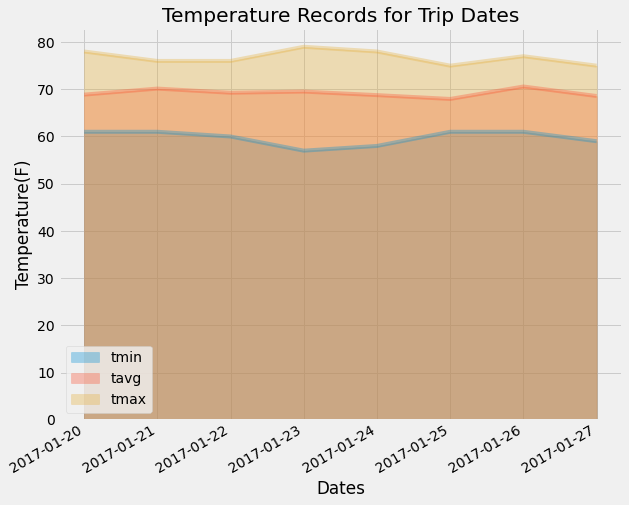

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.title(f"Temperature Records for Trip Dates")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.savefig("Figures/Plot Daily Normals.png")